![](img/575_banner.png)

# Lecture 3: Introduction to Hidden Markov Models (HMMs)

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Imports, LO

### Imports 

In [1]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append(os.path.join(os.path.abspath("."), "code"))
from plotting_functions import *
import IPython
from IPython.display import HTML, display

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Learning outcomes

From this lesson you will be able to

- explain the motivation for using HMMs
- define an HMM
- state the Markov assumption in HMMs
- explain three fundamental questions for an HMM
- apply the forward algorithm given an HMM
- explain supervised training in HMMs

<br><br><br><br>

## 1. Motivation

### 1.1 Speech recognition

- An important component of virtual assistants (e.g., Siri, Cortana, Google Home, Alexa) is speech recognition. 
- We ask such assistants questions. They convert the question into text, make sense of the question, and return the appropriate answer most of the times. 

In [2]:
url = "https://www.ibm.com/demos/live/speech-to-text/self-service/home"

IPython.display.IFrame(url, width=800, height=900)

- A number of speech recognition API's are available out there.
- You can access them with Python. 
- A Python module called [`SpeechRecognition`](https://pypi.org/project/SpeechRecognition/) can let you access some of these APIs. 
    - CMU Sphinx (works offline)
    - Google Speech Recognition
    - Google Cloud Speech API
    - Wit.ai
    - Microsoft Bing Voice Recognition
    - Houndify API
    - IBM Speech to Text
    - Snowboy Hotword Detection (works offline)
- Usually, you have to pay some money if you want to use these APIs.     

- In speech recognition, you are given a sequence of sound waves and your job is to recognize the corresponding sequence of phonemes or words. 
- Phonemes: distinct units of sound. For example: 
    - tree $\rightarrow$ T R IY
    - cat $\rightarrow$ K AE T
    - stats $\rightarrow$ S T AE T S
    - eks $\rightarrow$ E K S     
- There are ~44 phonemes in North American English. 
- Is it possible to use the ML models we learned in 571, 573, 563 for this problem?
- In written text, we know that certain transitions are more likely than others
    - "th" as in "this"
    - "sh" as in "shoe"
    - "ch" as in "chair"
    - "ck" as in "back"
- Which transition do you think is easier and more natural/efficient/common for phonemes? 
    - /s/ to /t/: "stop", "best", "fast"
    - /t/ and /r/: "try", "tree", "train"
    - /f/ to /v/: "of value"
    - /s/ to /b/
    - In other words is it easier to say "stop" or "of value"?
    
<br><br>

- Speech recognition is a sequence modeling problem. 
    - It's a good idea to incorporate sequential information in the model for speech recognition. 
- Many modern statistical speech recognition systems are based on hidden Markov models. 


### 1.2 HMMs intuition

**Observable Markov models** 

- Example
    - States: {uniformly, are, charming}   

![](img/observable_Markov.png)
<!-- <center> -->
<!-- <img src="img/observable_Markov.png" height="600" width="600"> -->
<!-- </center> -->

[Source](https://web.stanford.edu/~jurafsky/slp3/A.pdf)

**Hidden phenomenon**

Very often the things you observe in the real world can be thought of as a function of some other **hidden** variables.

Example 1: 
- Observations: Acoustic features of the speech signal, hidden states: phonemes that are spoken

Example 2: 
- Observations: Words, hidden states: parts-of-speech

![](img/hmm_pos_tagging.png)
<!-- <center> -->
<!-- <img src="img/hmm_pos_tagging.png" height="1000" width="1000"> -->
<!-- </center> -->


[Source](https://web.stanford.edu/~jurafsky/slp3/8.pdf)

More examples

- Observations: Encrypted symbols, hidden states: messages
- Observations: Exchange rates, hidden states: volatility of the market

<!-- ![](img/stock_market_hmm.png) -->

Recently, neural models have overshadowed HMMs in many areas, especially in NLP and tasks requiring the processing of long sequences. That said, HMMs are not obsolete. Their simplicity, interpretability, and efficiency in modeling temporal or sequential data make them suitable for applications where 
- the data sequences are not excessively long or
- the computational resources are limited

HMMS still shine in the following areas:
- Speech Recognition
- Bioinformatics
- Financial Modeling

<br><br><br><br>

## 2. HMM definition and example

- Last week we used the following toy example to demonstrate how do we learn initial state probabilities and transition probabilities in Markov models. 

- Imagine you're developing a system for a company interested in tailoring its services based on users' emotional states. (Though, remember, this is a simplified and hypothetical scenario to understand HMMs, not a real-world application due to privacy and ethical considerations.)
- In this scenario, the company cannot directly know a person's emotional state because it's 'hidden'. However, they can observe behaviors through activity on their platform, like the types of videos watched or search queries. 
  
![](img/activity-seqs.png)
<!-- <img src="img/activity-seqs.png" height="800" width="800"> -->

### 2.1 Markov process with hidden variables: Example

- Let's simplify above example. 
- Suppose you have a little robot that is trying to estimate the posterior probability that you are **Happy (H or 🙂)** or **Sad (S or 😔)**, given that the robot has observed whether you are doing one of the following activities: 
    - **Learning data science (L or 📚)**
    - **Eat (E or 🍎)** 
    - **Cry (C or 😿)** 
    - **Social media (F)**

- The robot is trying to estimate the unknown (hidden) state $Q$, where $Q =H$ when you are happy (🙂) and $Q = S$ when you are sad (😔). 
- The robot is able to observe the activity you are doing: $O = {L, E, C, F}$ 

- By observing activities, the goal is to infer the underlying emotional states (the hidden states) and understand the transition patterns between these states.

(Attribution: Example adapted from [here](https://www.cs.ubc.ca/~nando/340-2012/lectures/l6.pdf).)

- Example questions we are interested in answering are:
    - Given an HMM, what is the probability of observation sequence 📚📚😿📚📚? (this lecture)
    - - Given an HMM, what is the best possible sequence of state of mind (e.g.,🙂,🙂,😔,🙂,🙂 ) given an observation sequence (e.g., L,L,C,L,L or 📚📚😿📚📚). (next lecture)

### 2.2 HMM ingredients

- State space (e.g., 🙂 (H), 😔 (S))
- An initial probability distribution over the states
- Transition probabilities
- **Emission probabilities** 
    - Conditional probabilities for all observations given a hidden state
    - Example: Below $P(L|🙂) = 0.7$ and $P(L|😔) = 0.1$
    
![](img/HMM_example_small.png)

<!-- <center> -->
<!-- <img src="img/HMM_example.png" height="600" width="600"> -->
<!-- </center> -->

**Definition of an HMM**

- A hidden Markov model (HMM) is specified by the 5-tuple:  $\{S, Y, \pi, T, B\}$ 
    - $S = \{s_1, s_2, \dots, s_n\}$ is a set of states (e.g., moods)
    - **$Y = \{y_1, y_2, \dots, y_k\}$ is output alphabet (e.g., set of activities)**
    - $\pi = {\pi_1, \pi_2, \dots, \pi_n}$ is discrete initial state probability distribution 
    - Transition probability matrix $T$, where each $a_{ij}$ represents the probability of moving from state $s_i$ to state $s_j$
    - **Emission probabilities B = $b_i(o), i \in S, o \in Y\$**

- Yielding the state sequence and the observation sequences in an unrolled HMM 
    - State sequence: $Q = {q_0,q_1, q_2, \dots q_T}, q_i \in S$ 
    - Observation sequence: $O = {o_0,o_1, o_2, \dots o_T}, o_i \in Y$
<!-- ![](img/HMM_unrolling_timesteps.png) -->

<!-- <center> -->
<!-- <img src="img/HMM_example.png" height="600" width="600"> -->
<!-- </center> -->

<!-- <center> -->
<!-- <img src="img/HMM_unrolling_timesteps.png" height="700" width="700"> -->

<!-- </center> -->

Here is an example of an unrolled HMM for six time steps, a possible realization of a sequence of states and a sequence of observations. 

![](img/HMM_unrolling_timesteps.png)

<!-- <center> -->
<!-- <img src="img/HMM_unrolling_timesteps.png" height="800" width="800"> -->
<!-- </center> -->

- Each state produces only a single observation and the sequence of hidden states and the sequence of observations have the same length. 

### 2.2 HMM assumptions

- **The probability of a particular state only depends on the previous state.**
    * $P(q_i|q_0,q_1,\dots,q_{i-1})$ = $P(q_i|q_{i-1})$
    
- **The probability of an output observation $o_i$ depends only on the state that produces the observation and not on any other state or any other observation.** 
    * $P(o_i|q_0,q_1,\dots,q_{i}, o_0,o_1,\dots,o_{i-1})$ = $P(o_i|q_i)$

<!-- ![](img/HMM_unrolling_timesteps.png) -->


<br><br><br><br>

### 2.3 Three fundamental questions for an HMM

#### Likelihood
Given a model with parameters $\theta = <\pi, T, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?
#### Decoding
Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?
#### Learning
Training: Given a large observation sequence $O$ how do we choose the best parameters $\theta$ that explain the data $O$? 

<br><br>

## ❓❓ Questions for you

### Exercise 3.1: Select all of the following statements which are **True** (iClicker)

**iClicker join link: https://join.iclicker.com/ZTLY**

- (A) Emission probabilities in our toy example give us the probabilities of being happy or sad given that you are performing one of the four activities: Learn, Eat, Cry, Facebook.  
- (B) In hidden Markov models, the observation at time step $t$ is conditionally independent of previous observations and previous hidden states given the hidden state at time $t$. 
- (C) In hidden Markov models, given the hidden state at time $t-1$, the hidden state at time step $t$ is conditionally independent of the previous hidden states and observations. 
- (D) In hidden Markov models, each hidden state has a probability distribution over all observations. 

<br><br><br><br>

```{admonition} Exercise 3.1: V's Solutions!
:class: tip, dropdown
- B, C, D
```

### Exercise 3.2: Discuss the following questions with your neighbour. 
1. What are the parameters $\theta$ of a hidden Markov model?
2. Below is a hidden Markov model that relates numbers of ice creams eaten by Jason to the weather. Identify observations, hidden states, transition probabilities, and emission probabilities in the model.

![](img/ice-cream-hmm.png)

<!-- <img src="img/ice-cream-hmm.png" height="600" width="600"> -->

[Source](https://web.stanford.edu/~jurafsky/slp3/A.pdf)

```{admonition} Exercise 3.2: V's Solutions!
:class: tip, dropdown
1. initial state probabilities $\pi_0$, transition probabilities $T$, emission probabilities $B$
2. 
- Observations: 1, 2, 3
- Hidden states: HOT, COLD 
- transition probabilities: 

|               | HOT  | COLD |
| ------------- |:---------:| -----:|
| HOT         | 0.6       | 0.4   |
| COLD        | 0.5       | 0.5   |

Emission probabilities: 
|               | 1  | 2 | 3 | 
| ------------- |:---------:| -----:| -----:|
| HOT         | 0.2       | 0.4   | 0.4 |
| COLD        | 0.5       | 0.4   | 0.1 |

```

### Break (~5 mins)

![](img/eva-coffee.png)

<br><br><br><br>

## 3. Likelihood

In the context of HMMs, the likelihood of an observation sequence is the probability of observing that sequence given a particular set of model parameters $\theta$. 

Given a model with parameters $\theta = <\pi, T, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?

- Example: What's the probability of the sequence below? 

![](img/HMM_example_activity_seq_small.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_activity_seq.png" height="400" width="400"> -->
<!-- </center> -->

- Recall that in HMMs, the observations are dependent upon the hidden states in the same time step. Let's consider a particular state sequence. 
<br><br>

![](img/HMM_likelihood_known_hidden_small.png)
<!-- <center> -->
<!-- <img src="img/HMM_likelihood_known_hidden.png" height="500" width="500"> -->
<!-- </center> -->

### Probability of an observation sequence given the state sequence 

- Suppose we know both the sequence of hidden states (moods) and the sequence of activities emitted by them. 
- $P(O|Q) = \prod\limits_{i=1}^{T} P(o_i|q_i)$
- $P(E L F C|🙂 🙂 😔 😔) = P(E|🙂) \times P(L|🙂) \times P(F|😔) \times P(C|😔)$

### 3.1 Joint probability of observations and a possible hidden sequence 

- Let's consider the joint probability of being in a particular state sequence $Q$ and generating a particular sequence $O$ of activities. 

- $P(O,Q) = P(O|Q)\times P(Q) = \prod\limits_{i=1}^T P(o_i|q_i) \times \prod\limits_{i=1}^T P(q_i|q_{i-1})$ 

<br>

![](img/HMM_likelihood_unknown_hidden_small.png)

<!-- <center> -->
<!-- <img src="img/HMM_likelihood_unknown_hidden.png" height="600" width="500"> -->
<!-- </center> -->

For example, for our toy sequence: 

\begin{equation}
\begin{split}
P(E L F C, 🙂 🙂 😔 😔) = & P(🙂|start)\\ 
                          & \times P(🙂|🙂) \times P(😔|🙂) \times P(😔|😔)\\
                          & \times P(E|🙂) \times P(L|🙂) \times P(F|😔) \times P(C|😔)\\
                      = & 0.8 \times 0.7 \times 0.3 \times 0.6 \times 0.2 \times 0.7 \times 0.2 \times 0.6 
\end{split}
\end{equation}


### 3.2 Total probability of an observation sequence 

- But we do not know the hidden state sequence $Q$.
- We need to look at all combinations of hidden states. 
- We need to compute the probability of activity sequence (ELFC) by summing over all possible state (mood) sequences.  
- $P(O) = \sum\limits_Q P(O,Q) = \sum\limits_QP(O|Q)P(Q)$

\begin{equation}
\begin{split}
P(E L F C) = & P(E L F C,🙂🙂🙂🙂)\\ 
             & + P(E L F C,🙂🙂🙂😔)\\
             & + P(E L F C,🙂🙂😔😔) + \dots
\end{split}
\end{equation}

- Computationally inefficient 
    - For HMMs with $n$ hidden states and an observation sequence of $T$ observations, there are $n^T$ possible hidden sequences!!
    - In real-world problems both $n$ and $T$ are large numbers. 

**How to compute $P(O)$ cleverly?**

- To avoid this complexity we use **dynamic programming**; we remember the results rather than recomputing them. 
- We make a **trellis** which is an array of states vs. time.
- Note the alternative paths in the trellis. We are covering all the 16 combinations of states. 
- We compute $\alpha_i(t)$ at each $(i,t)$, which represents the probability of being in state $i$ at time $t$ after seeing all previous observations and the current observation at time step $t$. 

![](img/HMM_trellis_small.png)

<!-- <center> -->
<!-- <img src="img/HMM_trellis.png" height="400" width="400"> -->
<!-- </center> -->

### 3.3 The forward procedure

**Intuition**
- To compute $\alpha_j(t)$, we can compute $\alpha_{i}(t-1)$ for all possible states $i$ and then use our knowledge of $a_{ij}$ and $b_j(o_t)$.
- We compute the trellis left-to-right because of the convention of time.
- Remember that $o_t$ is fixed and known.

**Three steps of the forward procedure.**

- Initialization: Compute the $\alpha$ values for nodes in the first column of the trellis $(t = 0)$.
- Induction: Iteratively compute the $\alpha$ values for nodes in the rest of the trellis $(1 \leq t < T)$.
- Conclusion: Sum over the $\alpha$ values for nodes in the last column of the trellis $(t = T)$.

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->


#### 3.3.1 The forward procedure: Initialization $\alpha_🙂(0)$ and $\alpha_😔(0)$

- Compute the nodes in the first column of the trellis $(T = 0)$.
    * Probability of starting at state 🙂 and observing the activity E: $\alpha_🙂(0) = \pi_🙂 \times b_🙂(E) = 0.8 \times 0.2 = 0.16$ 
    * Probability of starting at state 😔 and observing the activity E: $\alpha_😔(0) = \pi_😔 \times b_😔(E) = 0.2 \times 0.1 = 0.02$  

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->


#### 3.3.2 The forward procedure: Induction

- Iteratively compute the nodes in the rest of the trellis $(1 \leq t < T)$.
-  To compute $\alpha_j(t+1)$ we can compute $\alpha_{i}(t)$ for all possible states $i$ and then use our knowledge of $a_{ij}$ and $b_j(o_{t+1})$ 
- $\alpha_j(t+1) = \sum\limits_{i=1}^n \alpha_i(t) a_{ij} b_j(o_{t+1})$

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->


**The forward procedure: Induction $\alpha_🙂(1)$**

- $\alpha_j(t+1) = \sum\limits_{i=1}^n \alpha_i(t) a_{ij} b_j(o_{t+1})$

- Probability of being at state 🙂 at $t=1$ and observing the activity L

\begin{equation}
\begin{split}
\alpha_🙂(1) = & \alpha_🙂(0)a_{🙂🙂}b_🙂(L) + \alpha_😔(0)a_{😔🙂}b_🙂(L)\\
             = & 0.16 \times 0.7 \times 0.7 + 0.02 \times 0.4 \times 0.7\\ 
             = & 0.084\\
\end{split}
\end{equation}

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->


**The forward procedure: Induction $\alpha_😔(1)$**
- $\alpha_j(t+1) = \sum\limits_{i=1}^n \alpha_i(t) a_{ij} b_j(o_{t+1})$
- Probability of being at state 😔 at $t=1$ and observing the activity L:
\begin{equation}
\begin{split}             
\alpha_😔(1) = & \alpha_🙂(0)a_{🙂😔}b_😔(L) + \alpha_😔(0)a_{😔😔}b_😔(L)\\
             = & 0.16 \times 0.3 \times 0.1 + 0.02 \times 0.6 \times 0.1\\
             = & 0.006\\
\end{split}
\end{equation}

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->

**The forward procedure: Induction $\alpha_🙂(2)$**

- $\alpha_j(t+1) = \sum\limits_{i=1}^n \alpha_i(t) a_{ij} b_j(o_{t+1})$

- Probability of being at state 🙂 at $t=2$ and observing the activity F

\begin{equation}
\begin{split}
\alpha_🙂(2) = & \alpha_🙂(1)a_{🙂🙂}b_🙂(F) + \alpha_😔(1)a_{😔🙂}b_🙂(F)\\
             = & 0.084 \times 0.7 \times 0.0 + 0.006 \times 0.4 \times 0.0\\ 
             = & 0.0\\
\end{split}
\end{equation}

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->

**The forward procedure: Induction $\alpha_😔(2)$**

- $\alpha_j(t+1) = \sum\limits_{i=1}^n \alpha_i(t) a_{ij} b_j(o_{t+1})$
- Probability of being at state 😔 at $t=2$ and observing the activity F:
\begin{equation}
\begin{split}             
\alpha_😔(2) = & \alpha_🙂(1)a_{🙂😔}b_😔(F) + \alpha_😔(1)a_{😔😔}b_😔(F)\\
             = & 0.084 \times 0.3 \times 0.2 + 0.006 \times 0.6 \times 0.2\\
             = & 0.00576\\
\end{split}
\end{equation}

<!-- ![](img/HMM_example_trellis.png) -->

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->

**The forward procedure: Induction $\alpha_🙂(3)$**

- $\alpha_j(t+1) = \sum\limits_{i=1}^n \alpha_i(t) a_{ij} b_j(o_{t+1})$

- Probability of being at state 🙂 at $t=3$ and observing the activity C:

\begin{equation}
\begin{split}
\alpha_🙂(3) = & \alpha_🙂(2)a_{🙂🙂}b_🙂(C) + \alpha_😔(2)a_{😔🙂}b_🙂(C)\\
             = & 0 \times 0.7 \times 0.1 + 0.00576 \times 0.4 \times 0.1\\ 
             = & 2.3 \times 10^{-4}\\
\end{split}
\end{equation}

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->

**The forward procedure: Induction $\alpha_😔(3)$**

- $\alpha_j(t+1) = \sum\limits_{i=1}^n \alpha_i(t) a_{ij} b_j(o_{t+1})$
- Probability of being at state 😔 at $t=3$ and observing the activity C:
\begin{equation}
\begin{split}             
\alpha_😔(3) = & \alpha_🙂(2)a_{🙂😔}b_😔(C) + \alpha_😔(2)a_{😔😔}b_😔(C)\\
             = & 0.0 \times 0.3 \times 0.6 + 0.00576 \times 0.6 \times 0.6\\
             = & 2.07 \times 10^{-3}\\
\end{split}
\end{equation}

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->

#### 3.3.3 The forward procedure: Conclusion

- Sum over all possible final states:
  * $P(O;\theta) = \sum\limits_{i=1}^{n}\alpha_i(T-1)$
  * $P(E,L,F,C) = \alpha_🙂(3) + \alpha_😔(3) = 2.3 \times 10^{-4} + 2.07 \times 10^{-3}$ 

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700"> -->
<!-- </center> -->


#### Recap: The forward algorithm
- The forward algorithm computes likelihood of a given observation sequence: $P(O;\theta)$. 
- For each state $i$, we calculated $\alpha_i(0), \alpha_i(1), \alpha_i(2), ...\alpha_i(t)$, which represent the probabilities of being in state $i$ at times $t$ knowing all the observations which came before and at time $t$. 
- The trellis was computed left to right and top to bottom.
- The forward algorithm stores the probabilities of all possible 1-state sequences (from the start), to store all possible 2-state sequences (from the start), to store all possible 3-state sequences (from the start) and so on. 

![](img/hmm_alpha_values.png)

- Sum over all possible final states:
  * $P(O;\theta) = \sum\limits_{i=1}^{n}\alpha_i(T-1)$
  * $P(E,L,F,C) = \alpha_🙂(3) + \alpha_😔(3) = 0.00023 + 0.00207 = 0.0023$ 

<!-- <center> -->
<!-- <img src="img/hmm_alpha_values.png" height="500" width="500">  -->
<!-- </center> -->

<br><br><br><br>

## 4. Supervised training of HMMs

### 4.1 Supervised training of HMMs

- Suppose we have training data where we have $O$ and corresponding $Q$, then we can use MLE to learn parameters $\theta = <\pi, T, B>$
- Get transition matrix and the emission probabilities. 
    - Suppose $i$, $j$ are unique states from the state space and $k$ is a unique observation.    
    - $\pi_0(i) = P(q_0 = i) = \frac{Count(q_0 = i)}{\#sequences}$
    - $a_{ij} = P(q_{t+1} = j|q_t = i) = \frac{Count(i,j)}{Count(i, anything)}$
    - $b_i(k) = P(o_{t} = k|q_t = i) = \frac{Count(i,k)}{Count(i, anything)}$

![](img/HMM_unrolling_timesteps.png)

<!-- <center> -->
<!-- <img src="img/HMM_unrolling_timesteps.png" height="700" width="700"> -->
<!-- </center> -->

- Suppose we have training data where we have $O$ and corresponding $Q$, then we can use MLE to learn parameters $\theta = <\pi, T, B>$
    - Count how often $q_{i-1}$ and $q_i$ occur together normalized by how often $q_{i-1}$ occurs with anything: 
      $p(q_i|q_{i-1}) = \frac{Count(q_{i-1} q_i)}{Count(q_{i-1} \text{anything})}$
    - Count how often $q_i$ is associated with the observation $o_i$.   
      $p(o_i|q_{i}) = \frac{Count(o_i \wedge q_i)}{Count(q_{i} \text{anything})}$    

<!-- ![](img/HMM_unrolling_timesteps.png) -->

<!-- <center>
<img src="img/HMM_unrolling_timesteps.png" height="700" width="700">
</center> -->

**In real life, all the calculations above are done with log probabilities for numerical stability.** 

### 4.2 HMM libraries

Usually, practitioners develop there own version of HMMs suitable for their application. But there are some popular libraries:  
- [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/)
- [pomegranate](https://github.com/jmschrei/pomegranate)
- [HTK Toolkit](https://htk.eng.cam.ac.uk/)
> Note that there are not many actively maintained off-the-shelf libraries available for supervised training of HMMs. [seqlearn](https://pypi.org/project/seqlearn/) used to be part of `sklearn`. But it's separated now and is not being maintained. 

Let's calculate the likelihood of observing an observation sequence given a particular set of model parameters $\theta$ using `hmmlearn`. 

![](img/HMM_example_small.png)

<!-- <img src="img/HMM_example.png" height="600" width="600"> -->

To run the code below successfully, you need install `networkx` and `graphviz`. 

```
conda install -c conda-forge graphviz
conda install -c conda-forge python-graphviz
conda install -c anaconda networkx
conda install -c anaconda pydot
conda install --channel conda-forge pygraphviz
```

In [3]:
from hmmlearn import hmm

# Initializing an HMM
states = ["Happy", "Sad"]
n_states = len(states)

symbols = ["Learn", "Eat", "Cry", "Facebook"]
n_observations = len(symbols)

model = hmm.CategoricalHMM(
    n_components=n_states, random_state=42
)  # for discrete observations

# Set the initial state probabilities
model.startprob_ = np.array([0.8, 0.2])

# Set the transition matrix
model.transmat_ = np.array([[0.7, 0.3], [0.4, 0.6]])

# Set the emission probabilities of shape (n_components, n_symbols)
model.emissionprob_ = np.array([[0.7, 0.2, 0.1, 0.0], [0.1, 0.1, 0.6, 0.2]])

Nodes:
['happy', 'sad']



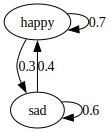

In [4]:
visualize_hmm(model, states=["happy", "sad"]) # user-defined function from code/plotting_functions.py

In [5]:
print("Emission probabilities: ")
pd.DataFrame(data=model.emissionprob_, columns=symbols, index=states)

Emission probabilities: 


,Learn,Eat,Cry,Facebook
Happy,0.7,0.2,0.1,0.0
Sad,0.1,0.1,0.6,0.2


- We can calculate the probability of an observation sequence efficiently using the forward algorithm. 
- In `hmmlearn`, we can use the `.score` method of the hmm model to get the log probabilities. 

In [6]:
obs_seq = np.array([[1], [0], [3], [2]])
label_obs_seq = map(lambda x: symbols[x], obs_seq.T[0])

In [7]:
# ?model.score

In [8]:
print(
    "Log likelihood of sequence %s is %s "
    % (list(label_obs_seq), model.score(obs_seq))
)

Log likelihood of sequence ['Eat', 'Learn', 'Facebook', 'Cry'] is -6.073108536148493 


<br><br><br><br>

## ❓❓ Questions for you

### Exercise 3.2: Select all of the following statements which are **True** (iClicker)

**iClicker join link: https://join.iclicker.com/ZTLY**

- (A) In the forward algorithm we assume that the observation sequence $O$ and the model parameters are fixed and known. 
- (B) In the forward algorithm, in our notation, $\alpha_{i}(t)$ represents the probability of being in state $i$ at time $t$ after seeing all the observations including the observation at time step $t$. 
- (C) In the forward algorithm $\alpha_i(t)$ does not know anything about the future time steps after the time step $t$. 
- (D) We conclude the forward procedure by summing over the $\alpha$ values at the last time step.
- (E) You can pass sequences of different lengths when training HMMs.  

```{admonition} Exercise 3.2: V's Solutions!
:class: tip, dropdown
- A, B, C, D, E
```

## ❓❓ Questions for you

### Exercise 3.3: Discuss the following question with your neighbour. 

- The forward procedure using dynamic programming needs only $\approx 2n^2T$ multiplications compared to the $\approx(2T)n^T$ multiplications with the naive approach!! Why? Discuss with your neighbour.
- Give an advantage of using the forward procedure compared to summing over all possible state combinations of length T. 

```{admonition} Exercise 3.3: V's Solutions!
:class: tip, dropdown

The forward procedure is a computationally efficient procedure compared to the method of summing over all possible state combinations of length $T$. The former requires $2Tn^T$ multiplications compared to $2n^2T$ multiplications in the latter, where $N$ is the number of states and $T$ is the number of time steps.

```

<br><br><br><br>

## Quick summary

### Summary

- Hidden Markov models (HMMs) model time-series with latent factors.
- There are tons of applications associated with them and they are more realistic than Markov models. 
- The most successful application of HMMs is speech recognition. 


### Important ideas we learned 

- HMM ingredients
    - Hidden states (e.g., Happy, Sad)
    - Output alphabet or output symbols (e.g., learn, study, cry, facebook)
    - Discrete initial state probability distribution
    - Transition probabilities
    - Emission probabilities    

![](img/HMM_example_small.png)

<!-- <center> -->
<!-- <img src="img/HMM_example.png" height="600" width="600"> -->
<!-- </center> -->

### Fundamental questions for HMMs 

- Three fundamental questions for HMMs: 
    - likelihood
    - decoding
    - parameter learning 
- The forward algorithm is a dynamic programming algorithm to efficiently calculate the probability of an observation sequence given an HMM. 

### Supervised training of HMMs 
- HMMs for POS tagging.
- Not many tools out there for supervised training of HMMs. 

### Coming up

- Decoding: Viterbi algorithm
    - Given an HMM model and an observation sequence, how do we efficiently compute the corresponding hidden state sequence. 
- Unsupervised training of HMMs (Optional)

<br><br>

### Resources

- [Hidden Markov Models chapter from Jurafsky and Martin](https://web.stanford.edu/~jurafsky/slp3/A.pdf)
- Attribution: Many presentation ideas in this notebook are taken from [Frank Rudzicz's slides](http://www.cs.toronto.edu/~frank/csc401/lectures2018/5-HMMs.pdf).
- [Jason Eisner's lecture on hidden Markov Models](https://vimeo.com/31374528)
- [Jason Eisner's interactive spreadsheet for HMMs](https://cs.jhu.edu/~jason/papers/eisner.hmm.xls)
- [Who each player is guarding?](https://www.youtube.com/watch?v=JvNkZdZJBt4)
- [The Viterbi Algorithm: A Personal History](https://arxiv.org/pdf/cs/0504020v2.pdf)
- [A nice demo of independent vs. Markov vs. HMMs for DNA](https://a-little-book-of-r-for-bioinformatics.readthedocs.io/en/latest/src/chapter10.html)